# Motivation

Wanted to work on a binary classification problem, with real-world messy data.

# Problem Statement

Overall: identify predictors that can be used in future surveys, and to more accurately target people who take the surveys. Maximize impact and cost effectiveness of poverty reduction interventions.


- Binary classification

- Competition metric is mean log loss:
$$ - \frac{1}{M} \sum\limits_{m = 1}^{M} \frac{1}{N_m} \sum\limits_{m = 1}^{N_m} [y_nlog(\hat{y})+(1-y_n)log(1-\hat{y_n})]$$

- Three countries 

In [34]:
import sys
sys.path.append("/Users/Bing/Documents/DS/DrivenData/Pover-T/Scripts/") # need to add path to the parent folder where CV.py is

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from PoverTHelperTools import *

# Overview of the data

In [2]:
hhold_a_train, hhold_b_train, hhold_c_train = load_hhold_train()
indiv_a_train, indiv_b_train, indiv_c_train = load_indiv_train()

- Two sets of data for each country. Individual and household data.

- We will need to predict on households, so the individual data is mainly available to construct new household level features.

- All have obfuscated features. 

- Could come across this on the job --> Facebook data.

In [69]:
hhold_a_train.head(2)

,wBXbHZmp,SlDKnCuu,KAJOWiiw,DsKacCdL,rtPrBBPl,tMJrvvut,jdetlNNF,maLAYXwi,vwpsXRGk,sArDRIyX,...,sDGibZrP,CsGvKKBJ,OLpGAaEu,LrDrWRjC,JCDeZBXq,HGPWuGlV,GDUPaBQs,WuwrCsIY,AlDbXTlZ,country
id,,,,,,,,,,,,,,,,,,,,,
46107,JhtDR,GUusz,TuovO,ZYabk,feupP,PHMVg,NDTCU,cLAGr,XAmOF,MwLvg,...,JqHnW,MaXfS,etZsD,idRwx,LPtkN,vkbkA,qQxrL,AITFl,aQeIm,A
82739,JhtDR,GUusz,TuovO,ZYabk,feupP,PHMVg,NDTCU,sehIp,lwCkE,MwLvg,...,JqHnW,MaXfS,HxnJy,idRwx,UyAms,vkbkA,qQxrL,AITFl,cecIq,A


In [73]:
indiv_a_train.head()

HeUgMnzF CaukPfUC MzEtIdUF gtnNTNam SWoXNmPc eXbOkwhI  OdXpbPGJ  \
id    iid                                                                   
80389 1      XJsPz    mOlYV    UFoKR    SSvEP    onRNG    YXCNt       4.0   
      2      XJsPz    mOlYV    axSTs    CXizI    onRNG    YXCNt       4.0   
      3      TRFeI    mOlYV    axSTs    CXizI    NDnCs    YXCNt       4.0   
      4      XJsPz    yAyAe    FRcdT    CXizI    onRNG    YXCNt       NaN   
39883 1      XJsPz    mOlYV    UFoKR    HIvIU    onRNG    YXCNt       4.0   

          XONDGWjH KsFoQcUV qYRZCuJD   ...   ukWqmeSS qqVibbSA MgCoFhXK  \
id    iid                              ...                                
80389 1      oArAw    kpkiH    fohru   ...        181    QQdHS    uEstx   
      2      ccbZA    HgfUG    fohru   ...        141    QQdHS    uEstx   
      3      fOUHD    HgfUG    oEref   ...         41    QQdHS    gCSRj   
      4      fOUHD    HgfUG    fohru   ...         16    QQdHS    uEstx   
39883 1      oArAw    kpkiH    fohru   ...        381    QQdHS    uEstx   

          rFpoTXAq RXcLsVAQ rQWIpTiG XizJGmbu xqUooaNJ   poor country  
id    iid                                                              
80389 1      Hikoa    zQvdC    xUYIC    juMSt    dSJoN   True       A  
      2      Hikoa    zQvdC    xUYIC    juMSt    JTCKs   True       A  
      3      Hikoa    zQvdC    rkLqZ    juMSt    JTCKs   True       A  
      4      Hikoa    zQvdC    jVHyH    GtHel    JTCKs   True       A  
39883 1      Hikoa    zQvdC    xUYIC    juMSt    UaIsy  False       A  

[5 rows x 42 columns]

In [3]:
print('Number of samples and features: ')
print('A', hhold_a_train.shape)
print('B', hhold_b_train.shape)
print('C', hhold_c_train.shape)

Number of samples and features: 
A (8203, 345)
B (3255, 442)
C (6469, 164)


Lots of features, not a huge amount of samples.

In [5]:
print('a_train contains:')
print(hhold_a_train.info())

a_train contains:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 8203 entries, 46107 to 39832
Columns: 345 entries, wBXbHZmp to country
dtypes: bool(1), float64(2), int64(2), object(340)
memory usage: 21.6+ MB
None


We have mostly categorical data for country A, some numerical data

# Target balance?

In [29]:
def target_ratio(df):
    positive = df[df['poor'] == 1].shape[0]
    return (positive/df.shape[0]*100)

for i in [hhold_a_train, hhold_b_train, hhold_c_train]:
    print('Percent True for country {}: {:0.2f}'.format(i['country'].unique(),target_ratio(i)))

Percent True for country ['A']: 45.14
Percent True for country ['B']: 7.71
Percent True for country ['C']: 15.04


-A is fairly balanced, but B and C are heavily imbalanced.

-Metric, and approach will depend on this knowledge.

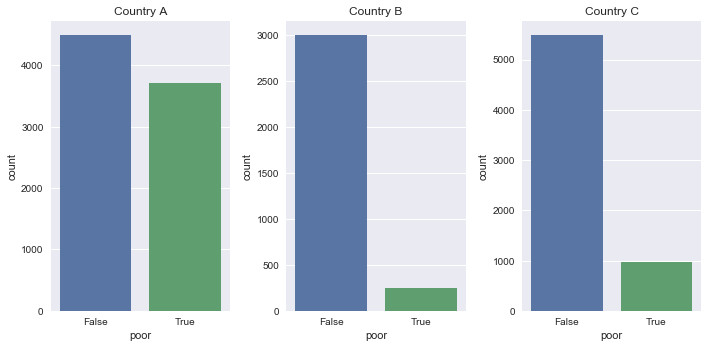

In [16]:
fig, ax = plt.subplots(1,3, figsize=(10,5))
sns.countplot(hhold_a_train['poor'], ax = ax[0])
ax[0].set_title('Country A')
sns.countplot(hhold_b_train['poor'], ax = ax[1])
ax[1].set_title('Country B')
sns.countplot(hhold_c_train['poor'], ax = ax[2])
ax[2].set_title('Country C')
sns.despine()
plt.tight_layout()

# Data cleaning and feature engineering

Started with a benchmark RandomForest model with all features. One model for each country, then concatenate results into a single submission. (~0.57 mean logloss)

- Can I improve with feature engineering and data cleaning?

#### NaNs

Only country B has NaNs, and there are alot. I just tossed them. Improved logloss to ~0.2 just by doing this.

In [100]:
print('Country A: ',hhold_a_train.columns[hhold_a_train.isnull().any()].tolist())
print('Country B: ',hhold_b_train.columns[hhold_b_train.isnull().any()].tolist())
print('Country C: ',hhold_c_train.columns[hhold_c_train.isnull().any()].tolist())

nulls_b = hhold_b_train[hhold_b_train.columns[hhold_b_train.isnull().any()].tolist()]
print(nulls_b.isnull().sum())

Country A:  []
Country B:  ['FGWqGkmD', 'BXOWgPgL', 'umkFMfvA', 'McFBIGsm', 'IrxBnWxE', 'BRzuVmyf', 'dnlnKrAg', 'aAufyreG', 'OSmfjCbE']
Country C:  []
FGWqGkmD    2653
BXOWgPgL     751
umkFMfvA    2365
McFBIGsm     751
IrxBnWxE    2983
BRzuVmyf    1461
dnlnKrAg    2723
aAufyreG    2346
OSmfjCbE     751
dtype: int64


In [32]:
def select_numerical(df):
    num = df.select_dtypes(include=['int64', 'float64'])   
    return num

def select_categorical(df):
    cat = df.select_dtypes(include=['object', 'category'])   
    return cat

In [35]:
# using country A as an example
a_num = select_numerical(hhold_a_train)
a_num['poor'] = hhold_a_train['poor']

#### Numericals

There are thousands of samples, but < 20 unique values for most of the numericals...maybe some are categorical? Maybe some have a range of limited values, like # of children?

Converting these into categoricals and one-hot encoding them performed the best.

In [48]:
for col in a_num.columns[:-1]: # [:-1] don't include 'poor' in the columns
    print(col, a_num[col].nunique())

nEsgxvAq 11
OMtioXZZ 13
YFMZwKrU 6
TiwRslOh 18


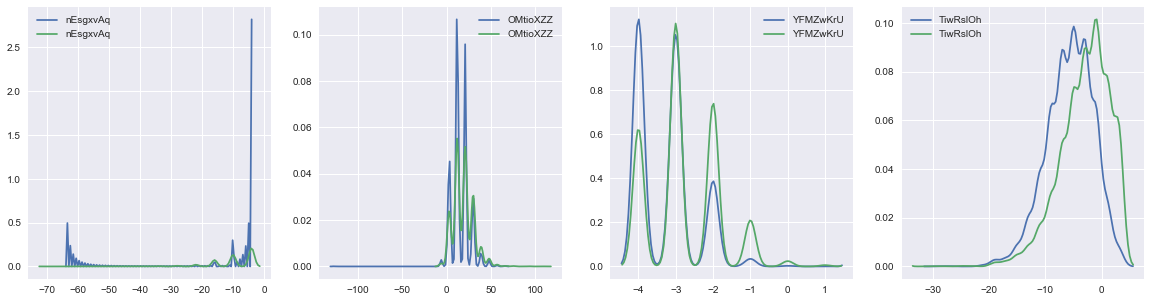

In [51]:
fig, ax = plt.subplots(1,4, figsize = (20,5))
for i, col in enumerate(a_num.columns[:-1]):
    sns.kdeplot(a_num[a_num['poor']==1][col], ax=ax[i])
    sns.kdeplot(a_num[a_num['poor']==0][col], ax=ax[i])

- Overlapping distributions, not predictive. But TwRsIOh looks like there's some seperation

#### Categoricals 

In [77]:
a_cat = select_categorical(hhold_a_train)
a_cat['poor'] = hhold_a_train['poor']

c_cat = select_categorical(hhold_c_train)
c_cat['poor'] = hhold_c_train['poor']

In [63]:
print('There are {} categorical columns.'.format(len(a_cat.columns[:-1])))

There are 340 categorical columns.


Let's see which ones are useful

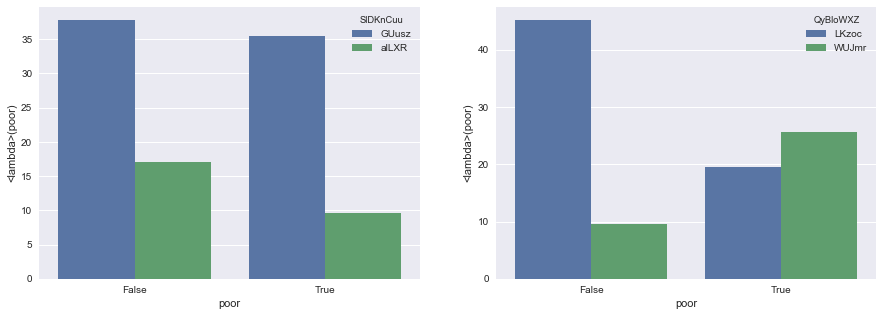

In [76]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
sns.barplot('poor', y = 'poor', hue = 'SlDKnCuu', data = a_cat,estimator=lambda x: len(x) / len(a_cat) * 100, ax = ax[0])
plt.ylabel('Percent of feature')
sns.barplot('poor', y = 'poor', hue = 'QyBloWXZ', data = a_cat,estimator=lambda x: len(x) / len(a_cat) * 100, ax = ax[1])

Most features in A looked like the one on the left; about even split.

The feature on the right is more distinct. There's ~45% probability that if a sample is LKzoc in feature QyBloWXZ, that it would be False for the target. 

My hypothesis is that since A is more balanced, features like QyBloWXZ would be more useful. Kept features like this, tossed the rest.

Country B and C are a different story.

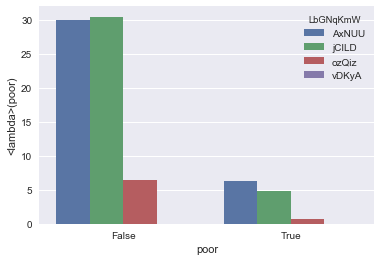

In [79]:
sns.barplot('poor', y = 'poor', hue = 'LbGNqKmW', data = c_cat,estimator=lambda x: len(x) / len(a_cat) * 100)

Basically all features looked like this.

Recall B and C are unbalanced, vast majority of targets in the training set is 'False'. So this doesn't tell us anything!

Tossed all categoricals for B and C

#### Other things:

Some features only had one unique value, so I tossed those.

Also tossed numerical columns that were highly correlated to others.

#### Creating new features

Added up number of responses in 'individual' data set per household. This might represent number of individuals in the household.

In [103]:
hhold_a_train['num_indiv'] = indiv_a_train.reset_index().groupby('id')['iid'].nunique()
hhold_a_train.head()

,wBXbHZmp,SlDKnCuu,KAJOWiiw,DsKacCdL,rtPrBBPl,tMJrvvut,jdetlNNF,maLAYXwi,vwpsXRGk,sArDRIyX,...,CsGvKKBJ,OLpGAaEu,LrDrWRjC,JCDeZBXq,HGPWuGlV,GDUPaBQs,WuwrCsIY,AlDbXTlZ,country,num_indiv
id,,,,,,,,,,,,,,,,,,,,,
46107,JhtDR,GUusz,TuovO,ZYabk,feupP,PHMVg,NDTCU,cLAGr,XAmOF,MwLvg,...,MaXfS,etZsD,idRwx,LPtkN,vkbkA,qQxrL,AITFl,aQeIm,A,6
82739,JhtDR,GUusz,TuovO,ZYabk,feupP,PHMVg,NDTCU,sehIp,lwCkE,MwLvg,...,MaXfS,HxnJy,idRwx,UyAms,vkbkA,qQxrL,AITFl,cecIq,A,3
9646,JhtDR,GUusz,BIZns,ZYabk,uxuSS,PHMVg,NDTCU,sehIp,qNABl,MwLvg,...,MaXfS,USRak,idRwx,UyAms,vkbkA,qQxrL,AITFl,cecIq,A,6
10975,JhtDR,GUusz,TuovO,ZYabk,feupP,PHMVg,NDTCU,sehIp,sPNOc,MwLvg,...,MaXfS,USRak,idRwx,UyAms,vkbkA,qQxrL,AITFl,cecIq,A,3
16463,JhtDR,alLXR,TuovO,ZYabk,feupP,PHMVg,NDTCU,cLAGr,NdlDR,MwLvg,...,MaXfS,etZsD,idRwx,UyAms,vkbkA,qQxrL,GAZGl,aQeIm,A,5


# Machine Learning

#### Cross validation

Difficult to create a cross validation that would emulate the test set. 

- Some things that helped:

- Stratified KFold:
    - Within the KFold CV loop:
        - Resample the minority class (Tried up and down sampling, as well as SMOTE) Up and Downsampling were similar in performance. SMOTE made things worse
        
- Using resampling on the whole train set to predict on test set made things worse! 

- Hypothesis: Test set and Train set distributions were different. Tried adveserial validation. 

- Result: Classifier can not distinguish between train and test set samples; they are of similar distributions.

- My guess now: Train set is highly unbalanced, but test set might be balanced.

#### Models

XGBoost was the best. Used GridSearch to tune better.

# Key Takeaway: Problem with metric

 Fundamental problem with the competition: Log loss is similar to using accuracy to measure performance on unbalanced data sets, it's not a good metric.

- Does not distinguish between False Positives/Negatives.
- Penalizes strongly confident but wrong predictions, but penalizes timid but wrong predictions much less.
- Example: with a threshold of 0.5, the model can predict 'False' with probability of ~0.4 or ~0.1
    - Log loss for 0.4 is 0.92
    - Log loss for 0.1 is 2.3!


- Should use another metric or combination of metrics


Demonstration:

In [109]:
# Note: activate env, then run CV_B.py and CV_B_resampled.py